# 金融预测2- 改进单一GRU模型，加入SE模型融合

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import copy
plt.rcParams['font.sans-serif']=['SimHei']#画图显示中文字

# 1、数据处理

In [13]:
#数据处理：提取处理特征、标准化、拆分数据集
def dataSet(time_steps=4):
    #读数据
    df = pd.read_csv("data//ch_data.csv",encoding="utf")
    #时间数据转换为时间戳
    df["date"] = df["date"].apply(lambda x:pd.to_datetime(x).value)
    #取特征列
    XAll = df.iloc[:,1:-1]
    #取结果列
    YAll = df.iloc[:,-1:]
    #划分数据集
    X_train,X_test,y_train,y_test = train_test_split(
        XAll,YAll,
        test_size = 0.3,#30%用做测试集
        random_state = 7
    )
    #归一化，标准化
    ssObj = StandardScaler()
    X_train_std = ssObj.fit_transform(X_train)
    X_test_std = ssObj.transform(X_test)#先拆分训练测试集，再标准化，保持真实性
    y_train_std = ssObj.fit_transform(y_train)
    y_test_std = ssObj.transform(y_test)
    
    #按时间序列变形：二维变三维
    #参数：1、训练集数据条数，2、时间步，3、特征数input_size，行列静态二维变为按时间动态交错输入带时序属性的三维，特征数因此打乱自适应）
    X_train_reshape = X_train_std.reshape(X_train_std.shape[0],time_steps,-1)
    X_test_reshape = X_test_std.reshape(X_test_std.shape[0],time_steps,-1)
    #根据模型需要变形Y
    y_train_reshape = y_train_std.reshape(y_train_std.shape[0],-1)#结果列拉平一列，一行数据对应一个结果
    y_test_reshape = y_test_std.reshape(y_test_std.shape[0],-1)
    
    return (X_train_reshape,y_train_reshape,X_test_reshape,y_test_reshape) 
    

In [14]:
print("训练集X:",dataSet()[0].shape,"\n训练集Y:",dataSet()[1].shape,"\n测试集X:",dataSet()[2].shape,"\n测试集Y:",dataSet()[3].shape)

训练集X: (1249, 4, 251) 
训练集Y: (1249, 1) 
测试集X: (536, 4, 251) 
测试集Y: (536, 1)


# 2、搭SE(Sparse Encoder)

#目的：在GRU之前加入SE，将输入数据降维后再输入GRU，达到加速收敛提升精度的目的

In [19]:
#SE建模
class SparseEncoder(torch.nn.Module):
    
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size,hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size,input_size)
        
    def forward(self,x):
        h1=torch.nn.functional.relu(self.fc1(x))#第一个全连接层把input输入降维
        out = torch.nn.functional.relu(self.fc2(h1))#第二层信息权重处理后维度还原，带着压维后的特征并保持未处理前一样的结构形状传递到GRU
        return out   
        

In [30]:
#GRU搭建
class GRUStock(torch.nn.Module):
    
    #初始化变量与模型函数
    def __init__(self,input_size,hidden_size,output_size,num_layers):
        super(GRUStock,self).__init__()
        #实例化SE模型
        self.se = SparseEncoder(input_size,hidden_size)
        self.gru = torch.nn.GRU(input_size,
                                hidden_size,
                                num_layers)#第二参本身GRU的隐层仍然需要，处理编码特征信息给fc识别
        self.fc = torch.nn.Linear(hidden_size,output_size)
      
    #向前传播计算运行
    def forward(self,x):
        #调取SE传入原始x做降维
        out1 = self.se(x)
        #输出二维变三维，符合GRU要求的输入格式，第二参数加时间步（X输入的格式分别为[inputsize,timesteps,-1]），取x.shape[1]
        #out2 = out1.unsqueeze(1).repeat(1,x.shape[1],1)
        #本例二维变三维加时间步的操作已经数据处理阶段完成，上面语句不需要再处理
        out2 = out1
        #SE处理后的数据传入GRU
        out3,_ = self.gru(out2)
        #经过gru的全连接层计算结果并返回
        rs_out = self.fc(out3[:,-1,:])#-1是保留最后一个隐层累计的信息，其余维度保持一致
        
        return rs_out
               

In [31]:
time_steps = 4
#读取数据转为GRU所需的tensor格式
(X_train_reshape,y_train_reshape,X_test_reshape,y_test_reshape) = dataSet(time_steps)

X_train = torch.Tensor(X_train_reshape)
y_train = torch.Tensor(y_train_reshape)
X_test = torch.Tensor(X_test_reshape)
y_test = torch.Tensor(y_test_reshape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([1249, 4, 251])
torch.Size([1249, 1])
torch.Size([536, 4, 251])
torch.Size([536, 1])


In [32]:
#设置超参数
input_size=X_train.shape[2]
hidden_size=64
output_size=1
num_layers =1
num_epochs = 800#训练多少轮
learning_rate = 0.001
time_steps = 4#数据输入的时间步长切分

#……SE模型的调用在GRU模型搭建中集成完成……

#实例化GRU
gruModel = GRUStock(input_size,hidden_size,output_size,num_layers)
#定义学习器
optimizer = torch.optim.Adam(gruModel.parameters(),lr=learning_rate,weight_decay=0.001)
#定义损失函数
criterion = torch.nn.MSELoss()

#用于记录每个epoch的loss值
train_loss=[]

#==训练==
min_loss_val = 10#初始化最小loss
best_model = None#定义初始最好模型
for epoch in range(num_epochs):
    optimizer.zero_grad()#梯度清零
    #调用模型输入数据，计算，前向传播
    output = gruModel(X_train)
    loss = criterion(output,y_train.float())#计算损失
    loss.backward()#反向传播
    optimizer.step()#更新
    
    #存储loss值
    train_loss.append(loss.item())
    
    #打印loss,50个epoch打印一次
    if epoch % 50 == 0:
        print(f"Epoch{epoch}loss：{loss.item()}")
        #最小loss置为最好模型并保存    
        if loss <= min_loss_val:
            min_loss_val = loss
            best_model = copy.deepcopy(gruModel)
            print("save best_model_SE-GRU")
            torch.save(best_model.state_dict(),'model//best_model_SE-GRU.pth')
gruModel = best_model



Epoch0loss：1.0232889652252197
save best_model_SE-GRU
Epoch50loss：0.3371201455593109
save best_model_SE-GRU
Epoch100loss：0.11259244382381439
save best_model_SE-GRU
Epoch150loss：0.0337570458650589
save best_model_SE-GRU
Epoch200loss：0.02138535864651203
save best_model_SE-GRU
Epoch250loss：0.0075021726079285145
save best_model_SE-GRU
Epoch300loss：0.0034110296983271837
save best_model_SE-GRU
Epoch350loss：0.0021266788244247437
save best_model_SE-GRU
Epoch400loss：0.009801520965993404
Epoch450loss：0.006849951110780239
Epoch500loss：0.024991344660520554
Epoch550loss：0.010872269980609417
Epoch600loss：0.0009443776216357946
save best_model_SE-GRU
Epoch650loss：0.009840336628258228
Epoch700loss：0.008209404535591602
Epoch750loss：0.0005863129044882953
save best_model_SE-GRU


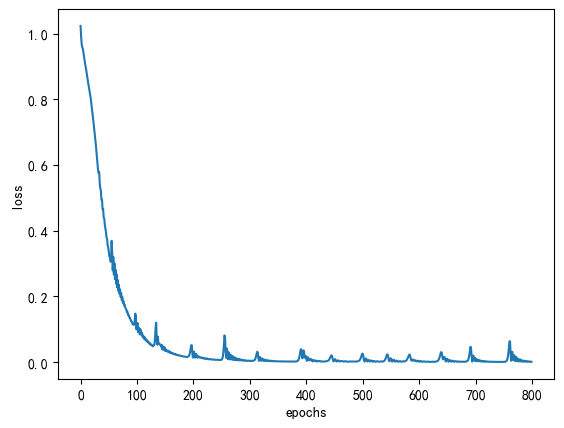

In [33]:
#画图
f1 = plt.figure()
plt.plot(range(len(train_loss)),train_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("loss_SE-GRU.png")
plt.show()

In [34]:
#预测
y_pred = gruModel(X_test)
y_pred_rs = y_pred.detach().numpy()#将张量分离并转换为NumPy数组
y_test_rs = y_test.detach().numpy()

C:\Users\A\AppData\Local\Temp\ipykernel_25156\3311178239.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("testSE-Gru.png")
C:\Users\A\.conda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


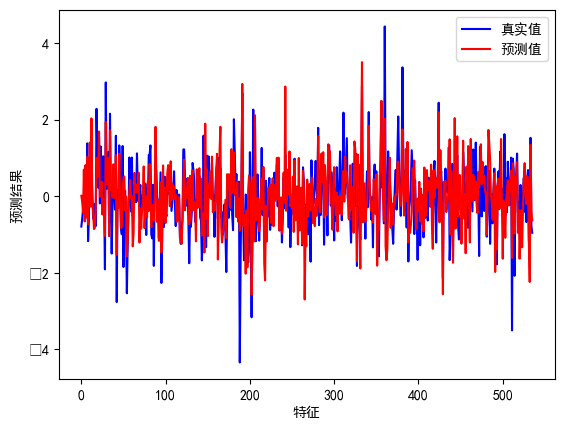

In [35]:
#画图
f2=plt.figure()
plt.plot(y_test_rs,color="blue",label="真实值")
plt.plot(y_pred_rs,color="red",label="预测值")
plt.legend()
plt.xlabel("特征")
plt.ylabel("预测结果")
plt.savefig("testSE-Gru.png")
plt.show()

In [36]:
#模型评估
test_rmse = np.sqrt(np.mean(np.square(y_pred_rs,y_test_rs)))
test_mae = np.mean(np.abs(y_pred_rs,y_test_rs))
print("test_rmse:",test_rmse,"\n","test_mae:",test_mae)

test_rmse: 0.83977175 
 test_mae: 0.6393968


#评估结果显示，GRU之前的SE对数据的降维处理有提高最终的模型预测在测试集上的表现，训练集的最后LOSS，加了SE的要高0.00012 =(0.00059-0.00047),整体说明对过拟合有抵御。

未使用SE test_rmse: 0.76050615   
未使用SE test_mae: 0.58456796  
使用SE后 test_rmse: 0.83977175  
使用SE后 test_mae: 0.6393968  
rmse提升了17%
mae提升了5%  

**但数据拆分是随机的，两个文件中的每次训练表现也有随机性  
加了SE后的训练时间有加快很多，此处未打印时间

# 3、因子分析特征重要性

#思路：遍历每个特征训练记录Loss，返回排序，loss低的重要


#方法同multiModelGRUGetFeature.ipynb页面处理

In [ ]:
# #其它计算特征重要性方法
# import lime

# # 使用 LIME 计算特征重要性
# explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df.iloc[:,1:-1], class_names=df.iloc[:,-1:].unique(), discretize_continuous=False)
# exp = explainer.explain_instance(X_train[0], gruModel.predict_proba, num_features=len(df.iloc[:,1:-1]), top_labels=1)

# # 打印特征重要性排序
# for feature, weight in exp.as_list():
#     print(feature, weight)